In [1]:
import seaborn as sns
import numpy as np
import pickle
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

gpu_devices = tf.config.experimental.list_physical_devices('GPU')
for device in gpu_devices:
    tf.config.experimental.set_memory_growth(device, True)

2022-02-25 13:39:45.469412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 13:39:45.474889: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-25 13:39:45.475204: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [3]:
NUM_CLASSES = 6

### The networks

#### Transformer

In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.embed_dim = embed_dim
        self.token_emb = layers.Embedding(input_dim= vocab_size, output_dim= embed_dim)
        self.maxlen = maxlen
        # self.pos_emb = layers.Embedding(input_dim= maxlen, output_dim= embed_dim)

    def get_angles(self, pos, i, embd_dim):
        angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(embd_dim))
        return pos * angle_rates

    def positional_encoding(self, max_pos_enc, embd_dim):
        angle_rads = self.get_angles(np.arange(max_pos_enc)[:, np.newaxis],
                                np.arange(embd_dim)[np.newaxis, :],
                                embd_dim)

        # apply sin to even indices in the array; 2i
        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

        # apply cos to odd indices in the array; 2i+1
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, x):
        # positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.positional_encoding(max_pos_enc= self.maxlen, embd_dim= self.embed_dim)
        # print(positions.shape)
        # positions = self.pos_encoding(positions)
        x = self.token_emb(x)
        # print(x.shape)
        return x + positions

In [5]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads= num_heads, key_dim= embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        # print('out1.shape:', out1.shape)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # print('ffn_output.shape:', ffn_output.shape)
        return self.layernorm2(out1 + ffn_output)

In [6]:
# def create_model_transformer(maxlen = 30121, vocab_size = 259,
#                             embed_dim = 50, num_heads = 2, 
#                             ff_dim = 16, dout = 0.1, 
#                             extra_dense_nodes = 20):
#     '''
#     embed_dim - Embedding size for each token
#     num_heads - Number of attention heads
#     ff_dim - Hidden layer size in feed forward network inside transformer
#     '''
#     inputs = layers.Input(shape=(maxlen,))
#     embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
#     x = embedding_layer(inputs)
#     transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
#     print(x.shape)
#     x = transformer_block(x)
#     x = layers.GlobalAveragePooling1D()(x)
#     x = layers.Dropout(dout)(x)
#     if extra_dense_nodes!= 0:
#         x = layers.Dense(extra_dense_nodes, activation= "relu")(x)
#         x = layers.Dropout(dout)(x)
#     outputs = layers.Dense(NUM_CLASSES, activation= "softmax")(x)

#     model= keras.Model(inputs=inputs, outputs= outputs)
#     model.summary()

#     return model

### Transformer and CNN

In [7]:
from tensorflow.keras.layers import Conv1D
 
@tf.autograph.experimental.do_not_convert # added to silence a warning related to TF
def create_model_cnn_transformer(maxlen = 30121, vocab_size = 259,
                                embed_dim = 50, num_heads = 2, 
                                ff_dim = 16, dout = 0.1,
                                cnn_filters = 64, cnn_window = 3, 
                                pool_window = 2, extra_dense_nodes = 20,
                                summary = False):
    '''
    embed_dim - Embedding size for each token
    num_heads - Number of attention heads
    ff_dim - Hidden layer size in feed forward network inside transformer
    '''
    # input
    inputs = layers.Input(shape=(maxlen,))
    # embeddding
    embedding_layer = TokenAndPositionEmbedding(inputs.shape[1], vocab_size, embed_dim)
    x = embedding_layer(inputs)
    # print('embedding output shape:', x.shape)
    # convolution
    x = Conv1D(filters= cnn_filters, kernel_size= cnn_window)(x)
    x = layers.MaxPooling1D(pool_size=pool_window)(x)
    # transformer
    transformer_block = TransformerBlock(x.shape[2], num_heads, ff_dim)
    # print('transformer_block input shape:', x.shape)
    x = transformer_block(x)
    # extra dense layers
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(dout)(x)
    if extra_dense_nodes!= 0:
        x = layers.Dense(extra_dense_nodes, activation= "relu")(x)
        x = layers.Dropout(dout)(x)
    # output
    outputs = layers.Dense(NUM_CLASSES, activation= "softmax")(x)

    model= keras.Model(inputs=inputs, outputs= outputs)
    if summary:
        model.summary()
    
    return model

### LSTM

In [8]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, LSTM, Embedding

# def create_LSTM_model(hidden_unit = 100, embedding_vec = 50):
#     model = Sequential()
#     model.add(Embedding(VOCAB_SIZE, embedding_vec, input_length= maxlen))
#     model.add(LSTM(hidden_unit))
#     model.add(Dense(NUM_CLASSES, activation='softmax'))
    
#     model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
#     model.summary()
#     return model

### Kmer method

#### Loading the saved data

In [9]:
with open('X_train_k3.pkl', 'rb') as f:
    X_train = pickle.load(f)
with open('Y_train_k3.pkl', 'rb') as f:
    Y_train = pickle.load(f)
    
X_train.shape, Y_train.shape

((1500, 30121), (1500,))

In [10]:
with open('X_test_list_k3.pkl', 'rb') as f:
    X_test = pickle.load(f)
with open('Y_test_list_k3.pkl', 'rb') as f:
    Y_test = pickle.load(f)

X_test[0].shape, Y_test[0].shape    

((1090, 30121), (1090,))

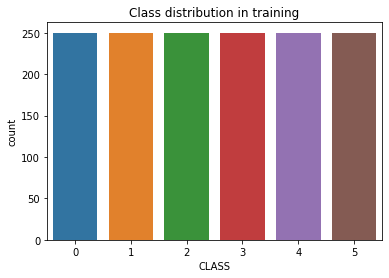

In [11]:
sns.countplot(x = Y_train)
plt.title('Class distribution in training')
plt.show()

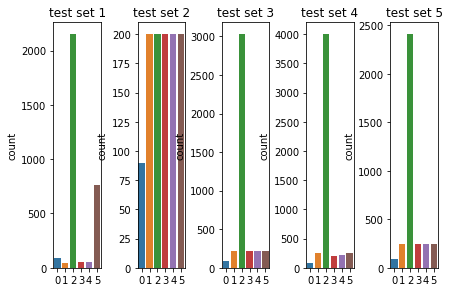

In [12]:
test_indicies = [2,3,4,5,1]
tests_order = [4,0,1,2,3] # the order that test sets are saved in Y_test
fig, ax= plt.subplots(1,len(Y_test))
fig.tight_layout()

for i in range(len(Y_test)):
    ax[i].set_title('test set '+ str(i+1))   
    sns.countplot(x = Y_test[tests_order[i]], ax=ax[i])

# plt.title('Class distribution in test sets', loc = 'left')
fig.show()

#### Training helpers

In [36]:
model_names = ['transformer_cnn_k3_32f_4pool',
            'transformer_cnn_k3_64f_4pool',
            'transformer_cnn_k3_128f_4pool']

In [37]:
lr_decay = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=5,
    verbose= 1
    )

es = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    verbose=1,
    patience=5,
    mode="auto",
    restore_best_weights=True,
)

adam_opt = tf.keras.optimizers.Adam(learning_rate= 3e-3)

In [38]:
def evaluate_model(model, model_name):
    model.load_weights('weights/'+model_name) # loads the best weight before evaluating
    for i in range(5):
        print('Test set {} F1 score:'.format(test_indicies[i]))
        preds = np.argmax(model.predict(X_test[i], batch_size=4), axis = 1)
        score = f1_score(Y_test[i], preds, average = 'weighted')
        print(score)
        with open('results/'+model_name+'_test_results.txt','a') as f:
            f.write('Test set '+str(test_indicies[i])+'F1 score:')
            f.write('\n'+str(score))
            f.write('\n')

In [39]:
# def evaluate_model(model, model_name):
#     model.load_weights('weights/'+model_name)
#     for i in range(5):
#         print('Test set {} results:'.format(test_indicies[i]))
#         with open(model_name+'_test_results.txt','a') as f:
#             f.write('Test set '+str(test_indicies[i])+' results:')
#             f.write('\n'+str(model.evaluate(X_test[i], Y_test[i], batch_size=4)))
#             f.write('\n')

In [40]:
def plot_history(history, model_name):
    print('Highest train acc: {:.3f} epoch: {}\nHighest val acc: {:.3f} epoch: {}'\
        .format(max(history.history['accuracy']), np.argmax(np.array(history.history['accuracy'])),
                max(history.history['val_accuracy']), np.argmax(np.array(history.history['val_accuracy']))))

    plt.title('Training history of '+ model_name)
    plt.plot(history.history['accuracy'],'ro-')
    plt.plot(history.history['val_accuracy'],'bx-')
    plt.legend(['accuracy','val_accuracy'])
    plt.savefig('results/'+model_name+'.png')
    plt.show()

In [41]:
def make_checkpointer(model_name):
    return tf.keras.callbacks.ModelCheckpoint(
    'weights/' + model_name, monitor='val_loss', verbose=0, save_best_only=True,
    save_weights_only=True)

In [42]:
metrics = ['accuracy']

#### CNN_Transformer

pool size smaller than 4 cannot be run by my GPU

In [32]:
eps = 20 #15

transformer_cnn_k3_32f_4pool
Epoch 1/20
375/375 [==============================] - 92s 245ms/step - loss: 0.8892 - accuracy: 0.5807 - val_loss: 0.6242 - val_accuracy: 0.7248 - lr: 0.0030
Epoch 2/20
375/375 [==============================] - 91s 244ms/step - loss: 0.5927 - accuracy: 0.6727 - val_loss: 0.6545 - val_accuracy: 0.8028 - lr: 0.0030
Epoch 3/20
375/375 [==============================] - 92s 244ms/step - loss: 0.4341 - accuracy: 0.7720 - val_loss: 0.4142 - val_accuracy: 0.7945 - lr: 0.0030
Epoch 4/20
375/375 [==============================] - 92s 245ms/step - loss: 0.3417 - accuracy: 0.8060 - val_loss: 0.4278 - val_accuracy: 0.8670 - lr: 0.0030
Epoch 5/20
375/375 [==============================] - 92s 245ms/step - loss: 0.2987 - accuracy: 0.8467 - val_loss: 0.4101 - val_accuracy: 0.9202 - lr: 0.0030
Epoch 6/20
375/375 [==============================] - 92s 245ms/step - loss: 0.2939 - accuracy: 0.8827 - val_loss: 0.8633 - val_accuracy: 0.7688 - lr: 0.0030
Epoch 7/20
375/375 [===

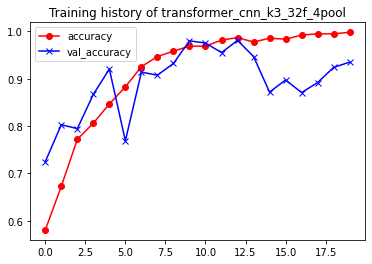

Test set 2 F1 score:
0.9751986427186882
Test set 3 F1 score:
0.9902582521030951
Test set 4 F1 score:
0.9945917627482705
Test set 5 F1 score:
0.9885778765600799
Test set 1 F1 score:
0.978563568443893


In [43]:
model_name = model_names[0]
print(model_name)

check_point = make_checkpointer(model_name)
model = create_model_cnn_transformer(cnn_filters=32, pool_window=4)

model.compile(optimizer= adam_opt, loss= "sparse_categorical_crossentropy", metrics= metrics)

history = model.fit(X_train, Y_train,
                    batch_size=4, epochs=eps,
                    validation_data=(X_test[0], Y_test[0]),
                    callbacks = [check_point, lr_decay])

plot_history(history, model_name)
evaluate_model(model, model_name)
# tf.keras.utils.plot_model(cnn_transformer1, to_file='cnn_transformer_32f_4pool.png', show_shapes=True)

transformer_cnn_k3_64f_4pool
Epoch 1/20
375/375 [==============================] - 102s 270ms/step - loss: 1.2368 - accuracy: 0.4327 - val_loss: 0.8511 - val_accuracy: 0.7248 - lr: 0.0030
Epoch 2/20
375/375 [==============================] - 101s 268ms/step - loss: 0.8395 - accuracy: 0.6087 - val_loss: 0.7092 - val_accuracy: 0.7239 - lr: 0.0030
Epoch 3/20
375/375 [==============================] - 101s 268ms/step - loss: 0.7446 - accuracy: 0.6153 - val_loss: 0.6833 - val_accuracy: 0.7339 - lr: 0.0030
Epoch 4/20
375/375 [==============================] - 101s 268ms/step - loss: 0.6689 - accuracy: 0.6427 - val_loss: 0.7860 - val_accuracy: 0.6303 - lr: 0.0030
Epoch 5/20
375/375 [==============================] - 101s 269ms/step - loss: 0.6513 - accuracy: 0.6560 - val_loss: 0.8346 - val_accuracy: 0.7239 - lr: 0.0030
Epoch 6/20
375/375 [==============================] - 101s 269ms/step - loss: 0.6492 - accuracy: 0.6467 - val_loss: 0.8134 - val_accuracy: 0.7229 - lr: 0.0030
Epoch 7/20
375/37

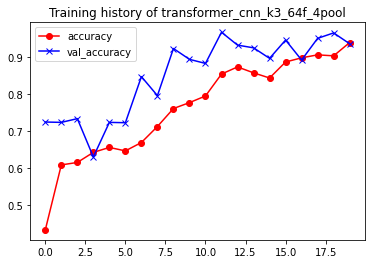

Test set 2 F1 score:
0.919684662084589
Test set 3 F1 score:
0.9405898605980496
Test set 4 F1 score:
0.9241338494641917
Test set 5 F1 score:
0.9419528254280054
Test set 1 F1 score:
0.8451301391772945


In [44]:
model_name = model_names[1]
print(model_name)
check_point = make_checkpointer(model_name)


model = create_model_cnn_transformer(cnn_filters=64, pool_window=4)

model.compile(optimizer= adam_opt, loss= "sparse_categorical_crossentropy", metrics=metrics)

history = model.fit(X_train, Y_train,
                    batch_size=4, epochs=eps,
                    validation_data=(X_test[0], Y_test[0]),
                    callbacks = [check_point, lr_decay])

plot_history(history, model_name)
evaluate_model(model, model_name)

# tf.keras.utils.plot_model(cnn_transformer1, to_file='cnn_transformer_32f_4pool.png', show_shapes=True)

In [45]:
model_name = model_names[2]
print(model_name)
check_point = make_checkpointer(model_name)

model = create_model_cnn_transformer(cnn_filters=128, pool_window=4)

model.compile(optimizer= adam_opt, loss= "sparse_categorical_crossentropy", metrics=metrics)

history = model.fit(X_train, Y_train,
                    batch_size=4, epochs=eps,
                    validation_data=(X_test[0], Y_test[0]),
                    callbacks = [check_point, lr_decay])

plot_history(history, model_name)
evaluate_model(model, model_name)

# tf.keras.utils.plot_model(cnn_transformer1, to_file='cnn_transformer_32f_4pool.png', show_shapes=True)

transformer_cnn_k3_128f_4pool
Epoch 1/20
375/375 [==============================] - 118s 312ms/step - loss: 1.8129 - accuracy: 0.1567 - val_loss: 1.7871 - val_accuracy: 0.1835 - lr: 0.0030
Epoch 2/20
375/375 [==============================] - 117s 312ms/step - loss: 1.7938 - accuracy: 0.1613 - val_loss: 1.7907 - val_accuracy: 0.1835 - lr: 0.0030
Epoch 3/20
375/375 [==============================] - 117s 312ms/step - loss: 1.7935 - accuracy: 0.1627 - val_loss: 1.7912 - val_accuracy: 0.1835 - lr: 0.0030
Epoch 4/20
375/375 [==============================] - 117s 312ms/step - loss: 1.7935 - accuracy: 0.1533 - val_loss: 1.7913 - val_accuracy: 0.1835 - lr: 0.0030
Epoch 5/20
375/375 [==============================] - 117s 312ms/step - loss: 1.7932 - accuracy: 0.1493 - val_loss: 1.7909 - val_accuracy: 0.1835 - lr: 0.0030
Epoch 6/20
375/375 [==============================] - ETA: 0s - loss: 1.7933 - accuracy: 0.1527
Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.001500000013038516.


KeyboardInterrupt: 

In [47]:
evaluate_model(model, model_name)


Test set 2 F1 score:
0.05689495768437522
Test set 3 F1 score:
0.005734597156398105
Test set 4 F1 score:
0.004743364981064487
Test set 5 F1 score:
0.009523809523809525
Test set 1 F1 score:
0.00033595435017914904
